<a href="https://colab.research.google.com/github/shalomorlando/machine_learning_tasks/blob/main/Dog_Breed_Classification_Using_Transfer_Learning_Technique_(MobileNetV2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook seeks to build a multiclass dog breed classification model while leveraging a pretrained model, the MobileNet V2 developed by google which was trained on ImageNet dataset and will be used to form our base model and feature extraction layer. 

#Then a classifier is built based on the extracted features

# INITIAL SETUP

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

# DATA PREPROCESSING
## Getting the data

In [2]:
import tensorflow_datasets as tfds

## Downloading the train_data

In [3]:
train_data, info = tfds.load(
    "stanford_dogs",
    split="train",
    as_supervised=True,
    with_info=True
) 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete9RXEIH/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete9RXEIH/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


## Exploring the data features

In [4]:
info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [ ]:
breed_names = np.array(info.features["label"].names)
breed_names

In [6]:
print(info.features["label"].num_classes)
#print(info.features["label"].names)
print(info.features["label"].str2int('n02089867-walker_hound'))

120
15


In [7]:
print("Number of training samples: %d" % tf.data.experimental.cardinality(train_data))

Number of training samples: 12000


## Seting up the valiation and test data

In [8]:
validation_data, test_data = tfds.load(
    "stanford_dogs",
    split=["test[:70%]", "test[:30%]"],
    as_supervised=True,

)

In [9]:
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_data))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_data))

Number of validation samples: 6006
Number of test samples: 2574


## Resizing the Images to the base models acceptable size

In [10]:
IMG_SIZE = (224, 224)

#resizing the images
train_data = train_data.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), y))
validation_data = validation_data.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), y))
test_data = test_data.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), y))

## Setting up the data for performance using batching, caching and prefetching

In [11]:
BATCH_SIZE = 32

#Cache and batch the data to optimize loading speed
train_data = train_data.cache().batch(BATCH_SIZE)
validation_data = validation_data.cache().batch(BATCH_SIZE)
test_data = test_data.cache().batch(BATCH_SIZE)

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

#Use buffered prefetching to load images from disk without having I/O become blocking
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)


### Checking the batch shape

In [13]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


### A view some of the images

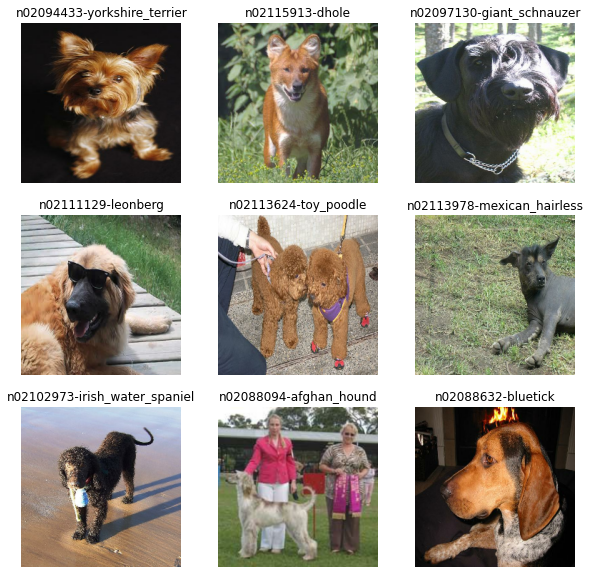

In [14]:
plt.figure(figsize=(10,10))
for image, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title( info.features["label"].int2str(int(labels[i])))
    plt.axis("off")

## Data Augmentation
### artificially introducing sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping

* Achieved by introducing a layer specifically for augmentation
* This layer can then be used in the model
* Will help expose the model to diff aspects of training and reduce overfitting


In [16]:
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.2),
    ]
)

### Applying this layer on an image to see what it does

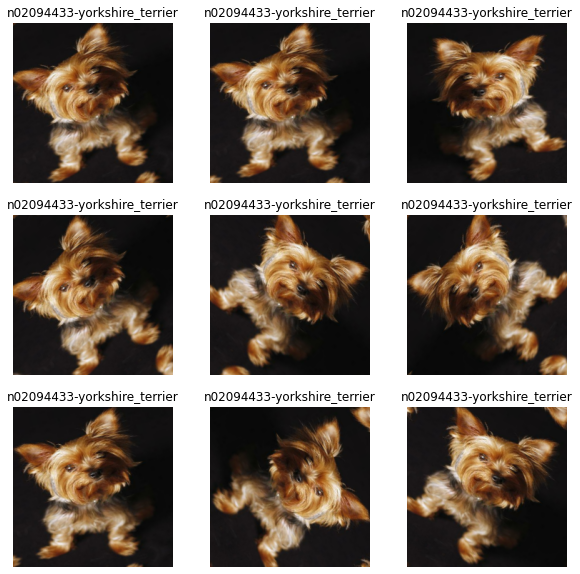

In [17]:
for images, labels in train_data.take(1):
  plt.figure(figsize=(10, 10))
  first_image = images[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(
        tf.expand_dims(first_image, 0), training=True
    )
    plt.imshow(augmented_image[0].numpy().astype("int32"))
    plt.title(info.features["label"].int2str(int(labels[0])))
    plt.axis("off")

## Rescaling pixel values
* The base model we will be using expects pixel values in the range [-1, 1]
* Currently our images have pixels values in the range [0, 255]
* to rescale the pixel values, we will be using the preprocessing method included in the model
* There are alternative methods for rescaling: A model may provide the details necessary


In [18]:
#option 1
## preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

#option 2

rescaling_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_data = train_data.map(lambda x, y: (rescaling_layer(x), y)) # Where x—images, y—labels.
validation_data = validation_data.map(lambda x, y: (rescaling_layer(x), y)) # Where x—images, y—labels.
test_data = test_data.map(lambda x, y: (rescaling_layer(x), y))

# COMPOSING THE MODEL
## Loading the base model

* Based Model will be a MobileNet V2 pretrained on ImageNet dataset.
* The knowledge if this model will help us classify the different dog breeds
* The Model will be used for feature extraction. Instead of using the very last classification layer, the bottlenecj layer will be used.
The bottleneck layer refers to the very last layer before the the flatten operation.

## Test model


In [19]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [20]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [21]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [23]:
num_classes = info.features["label"].num_classes

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 120)               153720    
Total params: 2,411,704
Trainable params: 153,720
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
predictions = model(image_batch)

In [25]:
predictions.shape

TensorShape([32, 120])

In [26]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [27]:
initial_epochs = 5

loss0, accuracy0 = model.evaluate(validation_data)

188/188 [==============================] - 167s 882ms/step - loss: 5.2249 - acc: 0.0047


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 5.22
initial accuracy: 0.00


In [29]:
NUM_EPOCHS = 10

history = model.fit(train_data,
                    validation_data=validation_data,
                    epochs=NUM_EPOCHS)

Epoch 1/10
375/375 [==============================] - 546s 1s/step - loss: 1.2563 - acc: 0.6924 - val_loss: 0.6384 - val_acc: 0.8097
Epoch 2/10
375/375 [==============================] - 582s 2s/step - loss: 0.3942 - acc: 0.8873 - val_loss: 0.5710 - val_acc: 0.8270
Epoch 3/10
375/375 [==============================] - 584s 2s/step - loss: 0.2489 - acc: 0.9377 - val_loss: 0.5541 - val_acc: 0.8318
Epoch 4/10
375/375 [==============================] - 586s 2s/step - loss: 0.1696 - acc: 0.9659 - val_loss: 0.5464 - val_acc: 0.8328
Epoch 5/10
375/375 [==============================] - 585s 2s/step - loss: 0.1210 - acc: 0.9808 - val_loss: 0.5450 - val_acc: 0.8343
Epoch 6/10
375/375 [==============================] - 582s 2s/step - loss: 0.0895 - acc: 0.9889 - val_loss: 0.5480 - val_acc: 0.8338
Epoch 7/10
375/375 [==============================] - 584s 2s/step - loss: 0.0683 - acc: 0.9927 - val_loss: 0.5527 - val_acc: 0.8323
Epoch 8/10
375/375 [==============================] - 582s 2s/step - 

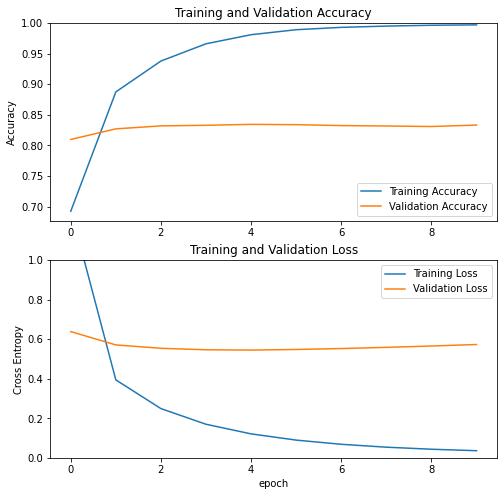

In [31]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# EVALUATE THE MODEL